In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#train_data = pd.read_csv('/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_train.csv')
#train_data_new = train_data[train_data['body'].notnull()]

#test_data = pd.read_csv("/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_test.csv")
#test_data_new = test_data[test_data['body'].notnull()]

data = pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2021_altın_mudahale/preprocessed_twitter_2021_altın_mudahale.csv')

In [4]:
data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,"50,000 finnish industrial workers threaten str...",0.000000,0.000000,Neutral
1,1,happened btc$100k eoy 🤷‍♂️ reminds fools gold ...,0.000000,0.000000,Neutral
2,2,plop supercooled ice 💦 copper gold swimmingspo...,0.400000,-0.150000,Negative
3,3,jp morgan turns bearish anything-- especially ...,1.000000,0.000000,Neutral
4,4,2021 year clean energy finally faced mining pr...,0.679451,0.157656,Positive


In [5]:
#combined_data = train_data.append(test_data, ignore_index=True)
data.shape

(8928, 5)

In [6]:
data["Analysis"].value_counts()

Neutral     4992
Positive    3088
Negative     848
Name: Analysis, dtype: int64

In [7]:
tokenized_data = data['tweet'].apply(lambda x: str(x).split()) # tokenizing

In [8]:
tokenized_data

0       [50,000, finnish, industrial, workers, threate...
1       [happened, btc$100k, eoy, 🤷‍♂️, reminds, fools...
2       [plop, supercooled, ice, 💦, copper, gold, swim...
3       [jp, morgan, turns, bearish, anything--, espec...
4       [2021, year, clean, energy, finally, faced, mi...
                              ...                        
8923    [happy, birthday, hong, joshua, 💙✨, loml, josh...
8924    [e, visto, che, oggi, non, era, giorno, già, a...
8925                 [come, carat, seventeen, carat, _17]
8926    [happyjoshuaday, happybirthdayjoshua, joshuada...
8927    [𝑇𝑎𝑔🏷⸒⸒, 𝙅𝙊𝙎𝙃𝙐𝘼🐰, '02(01), ｜, kanto｜, 同他◎, ♡, ...
Name: tweet, Length: 8928, dtype: object

In [9]:
from gensim.models import Word2Vec

In [10]:
model_w2v = Word2Vec(tokenized_data, size=256,  window=5)
model_w2v.train(tokenized_data, total_examples= len(tokenized_data), epochs=10)

(1260487, 1447380)

In [11]:
model_w2v.wv.most_similar(positive="gold")

[('gold?', 0.7369583249092102),
 ('xau/eur', 0.7112067937850952),
 ('bund', 0.708193302154541),
 ('inflation', 0.6942019462585449),
 ('german', 0.6915881633758545),
 ('investments', 0.6888067722320557),
 ('goldlimit', 0.6883636116981506),
 ('dowjones', 0.6818157434463501),
 ('premium', 0.6794795989990234),
 ('traded', 0.6764073371887207)]

In [12]:
# EEZ: Exclusive Economic Zone (Münhasır Ekonomik Bölge)
model_w2v.wv.most_similar(positive="exchange")

[('wallets', 0.969923198223114),
 ('😇', 0.962664783000946),
 ('cryptoexchange', 0.9616352319717407),
 ('🤓', 0.958768367767334),
 ('staking', 0.9430090188980103),
 ('bsc', 0.9297276735305786),
 ('farming', 0.9177988767623901),
 ('coinone', 0.9110254049301147),
 ('trustworthy', 0.9053659439086914),
 ('verifying', 0.9047296047210693)]

In [13]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [14]:
wordvec_arrays = np.zeros((len(tokenized_data), 256))

for i in range(len(data)):
    wordvec_arrays[i,:] = word_vector(tokenized_data[i], 256)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

<ipython-input-13-2f6882f45f7b>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(8928, 256)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#train_w2v = wordvec_df.iloc[:56819,:]
#test_w2v = wordvec_df.iloc[56819:,:]

X_train, x_test, y_train, y_valid = train_test_split(wordvec_df, data['Analysis'],  
                                                          random_state=42, 
                                                          test_size=0.2)

#print(train_w2v.shape, data['Analysis'].shape)

#xtrain_w2v = train_w2v.iloc[y_train.index,:]
#xvalid_w2v = train_w2v.iloc[y_valid.index,:]

In [17]:
X_train.shape

(7142, 256)

In [18]:
x_test.shape

(1786, 256)

In [19]:
y_train.shape

(7142,)

In [20]:
y_train

4081     Neutral
7890    Positive
2115    Positive
5118    Positive
641      Neutral
          ...   
5734    Positive
5191    Positive
5390    Positive
860      Neutral
7270    Positive
Name: Analysis, Length: 7142, dtype: object

In [21]:
y_valid.shape

(1786,)

In [22]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_valid)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [23]:
train_labels

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [24]:
test_labels.shape

(1786, 3)

In [25]:
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras import models
import keras.losses

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

epochs = 50
batch_size = 256
optimizer = "adam"
metrics = ["categorical_crossentropy", AUC(name='auc')]

# Build neural network
model = models.Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics= metrics)

history = model.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(x_test, test_labels))

Epoch 1/50
28/28 [==============================] - 2s 21ms/step - loss: 0.8341 - categorical_crossentropy: 0.8341 - auc: 0.8000 - val_loss: 0.7190 - val_categorical_crossentropy: 0.7190 - val_auc: 0.8536
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 0.6442 - categorical_crossentropy: 0.6442 - auc: 0.8889 - val_loss: 0.6134 - val_categorical_crossentropy: 0.6134 - val_auc: 0.8983
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 0.5585 - categorical_crossentropy: 0.5585 - auc: 0.9180 - val_loss: 0.5544 - val_categorical_crossentropy: 0.5544 - val_auc: 0.9179
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.5148 - categorical_crossentropy: 0.5148 - auc: 0.9300 - val_loss: 0.5167 - val_categorical_crossentropy: 0.5167 - val_auc: 0.9283
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 0.4751 - categorical_crossentropy: 0.4751 - auc: 0.9407 - val_loss: 0.4693 - val_categorical_crossentropy: 0.46

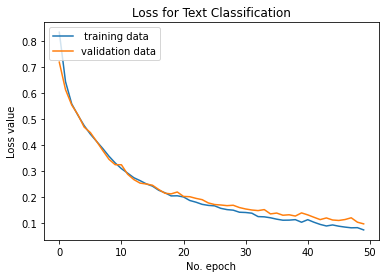

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

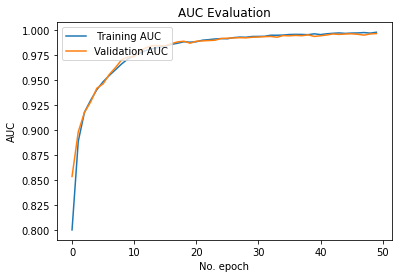

In [27]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [28]:
y__pred = model.predict(x_test)


56/56 [==============================] - 0s 1ms/step


In [29]:
y__pred.shape

(1786, 3)

In [30]:
y__pred = np.where((y__pred == 0),'Negative', y__pred)
y__pred = np.where((y__pred == '1'),'Neutral', y__pred)
y__pred = np.where((y__pred == '2'),'Positive', y__pred)

In [31]:
y_valid.shape

(1786,)